# COMP5623 Coursework on Image Caption Generation

Starter code.



## Text preparation 

We need to build a vocabulary.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Mounted Drive if using Colab; otherwise, your local path
root = "drive/My Drive/Colab Notebooks/data/" # <--- replace this with your root data directory
caption_dir = root + "Flickr8k_text/"                       # <--- replace these too
image_dir = root + "Flicker8k_Dataset/"                           # <---

token_file = "Flickr8k.token.txt"

A helper function to read in our ground truth text file.

In [0]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r')
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        lines.append(line.strip())
    file.close() 
    return lines

You can read all the ground truth captions (5 per image), into memory as follows:


In [0]:
lines = read_lines(caption_dir + token_file)

In [0]:
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # Increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [0]:
# In[]
import re

temp_cleaned_captions = []
image_ids=[]
words_map = {}
for i,line in enumerate(lines):
    # Parse the lines variable in the starter code, splitting the image ID from the caption text.
    temp_line = line.split('\t',1)[1]
    # Remove any punctuation (periods, commas, etc.)
    # Convert in-word characheristic to whitespace (wide-brimmed => wide brimmed)
    temp_line = re.sub(r'(\W)+'," ",temp_line)
    temp_line = temp_line.strip()
    # Split the caption text into words and trim any trailing whitespaces.
    temp_words_list = temp_line.split(" ")
    temp_cleaned_captions.append(temp_line)
    
    # Prepare for training
    temp_caption = line.split('\t',1)[0]
    temp_caption = re.split(".jpg[.]?[\d]?#\d",temp_caption)[0]
    image_ids.append(temp_caption)
    
    for word in temp_words_list:
        if not (word == "" or word == " "):
            word = word.lower()
            if (not word in words_map) or (words_map == {}):
                words_map[word] = 1
            else:
                words_map[word] = words_map[word] + 1


Extract all the words from ```lines```, and create a list of them in a variable ```words```, for example:

```words = ["a", "an", "the", "cat"... ]```

No need to worry about duplicates.


In [0]:
# In[]
words3_map = {}
for word in words_map:
    if not words_map[word] <= 3:
        words3_map[word] = words_map[word]

In [0]:
# In[]
# Prepare for training
cleaned_captions = []
for line in temp_cleaned_captions:
    line = line.lower()
    temp_splited_words = line.split(" ")
    for i,word in enumerate(temp_splited_words):
        if not word in words3_map:
            temp_splited_words.pop(i)
    cleaned_captions.append(" ".join(temp_splited_words).strip())

Build the vocabulary.

Add the rest of the words from the parsed captions:

vocab.add_word('new_word')

Don't add words that appear three times or less.

In [0]:
# In[]
# Create a vocab instance
vocab = Vocabulary()

# Add the token words first
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

# Remove any words which appear 3 times or less;
for word in words_map:
    if not words_map[word] <= 3:
        words3_map[word] = words_map[word]
        vocab.add_word(word)

## Dataset and loaders for training

Keeping the same order, concatenate all the cleaned words from each caption into a string again, and add them all to a list of strings ```cleaned_captions```. Store all the image ids in a list ```image_ids```.

In [0]:
print("cleaned_captions len: %s, image_ids len: %s" %(len(cleaned_captions),len(image_ids)))

cleaned_captions len: 40455, image_ids len: 40455


The dataframe for the image paths and captions.

In [0]:
import pandas as pd

data = {
    'image_id': image_ids,
    'path': [image_dir + image_id + ".jpg" for image_id in image_ids],
    'caption': cleaned_captions
}

data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])

In [0]:
data_df.head(n=5)

,image_id,path,caption
0,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/data/Flicker8k_...,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/data/Flicker8k_...,a girl going into a wooden building
2,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/data/Flicker8k_...,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/data/Flicker8k_...,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,drive/My Drive/Colab Notebooks/data/Flicker8k_...,a little girl in a pink dress going into a woo...


This is the Flickr8k class for the dataset.

In [0]:
from PIL import Image
import cv2
from nltk import tokenize
from torch.utils.data import Dataset

class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            df: df containing image paths and captions.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """ Returns one data pair (image and caption). """

        vocab = self.vocab

        caption = self.df['caption'][index]
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        # Looks like [1, 4, ......, 21, 2]
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        # image 为像素矩阵，target是一组vocab中的索引组成的张量
        return image, target

    def __len__(self):
        return len(self.df)

We need to overwrite the default PyTorch ```collate_fn()``` because our ground truth captions are sequential data of varying lengths. The default ```collate_fn()``` does not support merging the captions with padding.

You can read more about it here: https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 

In [0]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    # 按照data变量中target的长度进行排序
    data.sort(key=lambda x: len(x[1]), reverse=True)
    # 差分成images数组和captions数组
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    # 形成一个len()*max()的张量，填充0
    targets = torch.zeros(len(captions), max(lengths)).long()
    # 填充值
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

Now we define the data transform.

In [0]:
from torchvision import transforms

# Crop size matches the input dimensions expected by the pre-trained ResNet
data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])

Initialising the datasets. The only twist is that every image has 5 ground truth captions, so each image appears five times in the dataframe. We don't want an image to appear in more than one set.

In [0]:
unit_size = 5

train_split = 0.95 # Defines the ratio of train/test data.

# We didn't shuffle the dataframe yet so this works
train_size = unit_size * round(len(data_df)*train_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:train_size].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[(train_size):].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

Write the dataloaders ```train_loader``` and ```test_loader``` - explicitly replacing the collate_fn:

```train_loader = torch.utils.data.DataLoader(
  ...,
  collate_fn=caption_collate_fn
)```

Set train batch size to 128 and be sure to set ```shuffle=True```

In [0]:
import torch

BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset=dataset_train,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=caption_collate_fn,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=dataset_test,
                                          batch_size=BATCH_SIZE,
                                          collate_fn=caption_collate_fn,
                                          shuffle=False)

## Encoder and decoder models

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # Complete graph here. Remember to put the ResNet layer in a with torch.no_grad() block
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        if approach == "lstm":
            self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        elif approach == "rnn":
            self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        if approach == "lstm":
            hiddens, _ = self.lstm(packed) # Replace with self.rnn when using RNN
        elif approach == "rnn":
            hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            if approach == "lstm":
                 hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            elif approach == "rnn":
                 hiddens, states = self.rnn(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

Set training parameters.

In [0]:
import time

embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 10
save_step = 1
total_step = len(train_loader)

approach = 'lstm' # lstm / rnn
epoch_id = "5"
logdir = "drive/My Drive/Colab Notebooks/logs/"+approach
use_pretrain_modol = True 

dt = time.strftime('%Y%m%d_%H%M',time.localtime())
print(dt)

20200414_1747


Initialize the models and set the learning parameters.

In [0]:
import numpy as np

# Build the models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


## Training the model

In [0]:
def train_process():
    all_loss = []
    avg_loss = []
    for epoch in range(num_epochs):
        epoch_loss = []
        start_time = time.time()
        loop_time = time.time()
        for i, (images, captions, lengths) in enumerate(train_loader):
            # Set mini-batch dataset
            images = images.to(device)
            captions = captions.to(device)

            # Packed as well as we'll compare to the decoder outputs
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)

            loss = criterion(outputs, targets)
            
            # Zero gradients for both networks
            decoder.zero_grad()
            encoder.zero_grad()

            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            all_loss.append(loss.item())
            # Print log info
            if i % log_step == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Time: {:.2f} min'
                    .format(epoch+1, num_epochs, i, total_step, loss.item(), (time.time() - loop_time)/60 ))
                loop_time = time.time()
                # torch.save(decoder.state_dict(), '{}/{}-decoder-{}-{}.ckpt'.format(logdir, dt, epoch+1, i+1))
                # torch.save(encoder.state_dict(), '{}/{}-encoder-{}-{}.ckpt'.format(logdir, dt, epoch+1, i+1))

        avg_loss.append(sum(epoch_loss)/len(epoch_loss))

        print('Epoch [{}/{}], AvgLoss: {:.4f}, Time: {:.2f} min'
            .format(epoch+1, num_epochs, sum(epoch_loss)/len(epoch_loss), (time.time() - start_time) / 60)) 
        
        torch.save(decoder.state_dict(), '{}/{}-decoder-{}.ckpt'.format(logdir, dt, epoch+1))
        torch.save(encoder.state_dict(), '{}/{}-encoder-{}.ckpt'.format(logdir, dt, epoch+1))

    file1=open('{}/{}-all_loss.txt'.format(logdir, dt),'w') 
    for i in all_loss:
        file1.write(str(i)+'\n')
    file1.close() 

    file2=open('{}/{}-avg_loss.txt'.format(logdir, dt),'w')
    for i in avg_loss:
        file2.write(str(i)+'\n')
    file2.close() 

    return all_loss, avg_loss

In [0]:
# Train the models
start_time0 = time.time()
if not use_pretrain_modol: 
    all_loss, avg_loss  = train_process()
    elapsed = (time.time() - start_time0) / 60
    print(f'Total Time: {elapsed:.2f} min')   
else:
    print(f'Using pretrained model, calling next process.')

Using pretrained model, calling next process.


In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

# print the loss curve
if not use_pretrain_modol:
    x1 = list(range(0,total_step*num_epochs))
    x2 = [total_step*(0.5+i) for i in range(0,num_epochs)]
    y1 = all_loss
    y2 = avg_loss

    plt.plot(x1, y1, label="Loss for batch", color='orange')
    plt.plot(x2, y2, label="Loss for epoch", color='blue', linewidth=2.0)

    ax=plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(total_step))

    plt.xticks(x2,list(range(1,num_epochs+1)))

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss\n')
    plt.legend()
    plt.show() 

    if approach == 'lstm':
        print(f'LSTM, average training set loss at each epoch: {avg_loss}')
    elif approach =='rnn':
        print(f'RNN, average training set loss at each epoch: {avg_loss}')

Evaluate the model

In [0]:
def eval_process():
    # Test the model
    encoder.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    decoder.eval()

    if use_pretrain_modol:
        print(f'Using pretrained model')
        encoder.load_state_dict(torch.load(encoder_path))
        decoder.load_state_dict(torch.load(decoder_path))

    with torch.no_grad():
        loss_list = []
        for i, (images, captions, lengths) in enumerate(test_loader):
            # Set mini-batch dataset
            images = images.to(device)
            captions = captions.to(device)

            # Packed as well as we'll compare to the decoder outputs
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)

            loss = criterion(outputs, targets)
            loss_list.append(loss.item())
        
        avg_test_loss = sum(loss_list)/len(loss_list)
        
        if approach == 'lstm':
            print(f'LSTM, test set loss: {avg_test_loss}')
        elif approach =='rnn':
            print(f'RNN, test set loss: {avg_test_loss}')
    return avg_test_loss

In [0]:
approach = 'lstm'
logdir = "drive/My Drive/Colab Notebooks/logs/"+approach
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

if approach == 'lstm':
    encoder_path = logdir+"/20200413_0223-encoder-5.ckpt" 
    decoder_path = logdir+"/20200413_0223-decoder-5.ckpt"
elif approach =='rnn':
    encoder_path = logdir+"/20200412_2227-encoder-5.ckpt" 
    decoder_path = logdir+"/20200412_2227-decoder-5.ckpt"

eval_process()


Using pretrained model
LSTM, test set loss: 2.602965846657753


2.602965846657753

In [0]:
approach = 'rnn'
logdir = "drive/My Drive/Colab Notebooks/logs/"+approach
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

if approach == 'lstm':
    encoder_path = logdir+"/20200413_0223-encoder-5.ckpt" 
    decoder_path = logdir+"/20200413_0223-decoder-5.ckpt"
elif approach =='rnn':
    encoder_path = logdir+"/20200412_2227-encoder-5.ckpt" 
    decoder_path = logdir+"/20200412_2227-decoder-5.ckpt"
    
eval_process()

Using pretrained model
RNN, test set loss: 2.7249577343463898


2.7249577343463898

Generate caption

In [0]:
from nltk.translate.bleu_score import sentence_bleu

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def tensor_to_image(tensor):
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)
    return image

def sample_process(index, transform):
    # Prepare an image
    image_path = dataset_test.df['path'][index]
    print(f'df_index: {index}, image_path: {image_path}\n')
    image = load_image(image_path, transform)
    image_tensor = image.to(device)

    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    print(f'Generated index: {sampled_ids}')
    print('Generated sentence: %s\n' % ' '.join(sampled_caption))

    # Print out the image and the generated caption
    original_image = Image.open(image_path)

    plt.subplot(1,2,1)
    plt.title("Original image")
    plt.imshow(np.asarray(original_image))
    plt.subplot(1,2,2)
    plt.title("After Transformation")
    plt.imshow(tensor_to_image(image))
    plt.show()

    reference = []
    ref_captions = dataset_test.df['caption'][(index//5)*5:((index//5)*5)+5].tolist()
    for cap in ref_captions:
        reference.append(cap.split(' '))
    if sampled_caption.count('<start>') > 0:
        sampled_caption.remove('<start>')
    if sampled_caption.count('<end>') > 0:
        sampled_caption.remove('<end>')
    candidate = sampled_caption
    gram1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    gram2 = sentence_bleu(reference, candidate, weights=(0.66, 0.33, 0, 0))
    gram3 = sentence_bleu(reference, candidate, weights=(0.6, 0.3, 0.1, 0))
    gram4 = sentence_bleu(reference, candidate, weights=(0.5, 0.25, 0.15, 0.1))

    print('Reference: ')
    for ref in reference:
        print(' '.join(ref))
    print('\nCandidate: \n%s\n' % ' '.join(candidate))
    print('BLEU Cumulative 1-gram: %f' % gram1)
    print('BLEU Cumulative 2-gram: %f' % gram2)
    print('BLEU Cumulative 3-gram: %f' % gram3)
    print('BLEU Cumulative 4-gram: %f' % gram4)
    return gram1,gram2,gram3,gram4

Find out longest and shortest captions index

In [0]:
avg_len = []
for index in range(len(dataset_test)//5):
    reference = []
    cap_len = []
    ref_captions = dataset_test.df['caption'][(index//5)*5:((index//5)*5)+5].tolist()
    for cap in ref_captions:
        caplist = cap.split(' ')
        reference.append(caplist)
        cap_len.append(len(caplist))
    avg_len.append(sum(cap_len)/len(cap_len))

print(min(avg_len))
for i in range(len(avg_len)):
    if avg_len[i]==min(avg_len):
        print(i)

print(max(avg_len))
for i in range(len(avg_len)):
    if avg_len[i]==max(avg_len):
        print(i)

7.0
360
361
362
363
364
17.0
145
146
147
148
149


Print in details

Using pretrained model
df_index: 145, image_path: drive/My Drive/Colab Notebooks/data/Flicker8k_Dataset/543102698_38e7e38bbc.jpg

Generated index: [  1   4  74 142   6   4 108 155   9 138   6  59  13   4 665   2   4  76
   6   4]
Generated sentence: <start> a young boy in a red shirt is standing in front of a fountain <end>



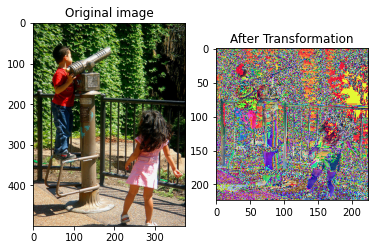

Reference: 
a little boy in a red shirt plays with a park telescope while a girl in a pink skirt watches
a little boy plays with a telescope in a park while a little girl watches
a little boy uses a telescope to view an object far away while a little girl stands nearby and watches
a young boy uses a water gun as a young girl watches
the boy in a red shirt plays with the telescope as a girl in a pink dress watches

Candidate: 
a young boy in a red shirt is standing in front of a fountain

BLEU Cumulative 1-gram: 0.598540
BLEU Cumulative 2-gram: 0.538919
BLEU Cumulative 3-gram: 0.507455
BLEU Cumulative 4-gram: 0.440031
df_index: 360, image_path: drive/My Drive/Colab Notebooks/data/Flicker8k_Dataset/566921157_07c18a41e2.jpg

Generated index: [  1   4  29   9 114 119  24 137   2   4 300   6 127 214   2  24 338   2
  24 380]
Generated sentence: <start> a dog is running through the water <end>



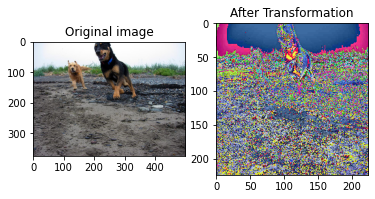

Reference: 
a brown and a brown dog are running
two dogs running in the dirt
two dogs running over packed dirt and rocks
two dogs run through mud
two large dogs run along a muddy path

Candidate: 
a dog is running through the water

BLEU Cumulative 1-gram: 0.714286
BLEU Cumulative 2-gram: 0.800858
BLEU Cumulative 3-gram: 0.817190
BLEU Cumulative 4-gram: 0.845154


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
approach = 'lstm'
logdir = "drive/My Drive/Colab Notebooks/logs/"+approach
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

if approach == 'lstm':
    encoder_path = logdir+"/20200413_0223-encoder-5.ckpt" 
    decoder_path = logdir+"/20200413_0223-decoder-5.ckpt"
elif approach =='rnn':
    encoder_path = logdir+"/20200412_2227-encoder-5.ckpt" 
    decoder_path = logdir+"/20200412_2227-decoder-5.ckpt"
encoder.eval()
if use_pretrain_modol:
    print(f'Using pretrained model')
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

for df_index in [145,360]:
    sample_process(df_index, data_transform)

Using pretrained model
df_index: 145, image_path: drive/My Drive/Colab Notebooks/data/Flicker8k_Dataset/543102698_38e7e38bbc.jpg

Generated index: [  1   4 142   6   4 108 155  30 156 157   9 598   4 511   2   2   2   2
   2   2]
Generated sentence: <start> a boy in a red shirt and blue jeans is riding a bike <end>



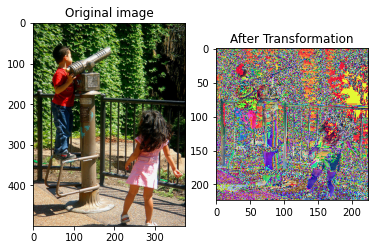

Reference: 
a little boy in a red shirt plays with a park telescope while a girl in a pink skirt watches
a little boy plays with a telescope in a park while a little girl watches
a little boy uses a telescope to view an object far away while a little girl stands nearby and watches
a young boy uses a water gun as a young girl watches
the boy in a red shirt plays with the telescope as a girl in a pink dress watches

Candidate: 
a boy in a red shirt and blue jeans is riding a bike

BLEU Cumulative 1-gram: 0.615385
BLEU Cumulative 2-gram: 0.505111
BLEU Cumulative 3-gram: 0.471981
BLEU Cumulative 4-gram: 0.417595
df_index: 360, image_path: drive/My Drive/Colab Notebooks/data/Flicker8k_Dataset/566921157_07c18a41e2.jpg

Generated index: [  1   4  29 124 119  24 170   2   2   2   2   2   2   2   2   2   2   2
   2   2]
Generated sentence: <start> a dog runs through the snow <end>



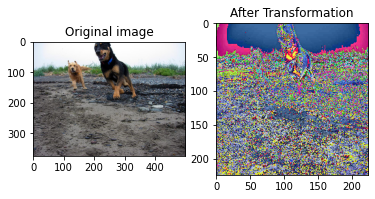

Reference: 
a brown and a brown dog are running
two dogs running in the dirt
two dogs running over packed dirt and rocks
two dogs run through mud
two large dogs run along a muddy path

Candidate: 
a dog runs through the snow

BLEU Cumulative 1-gram: 0.666667
BLEU Cumulative 2-gram: 0.765208
BLEU Cumulative 3-gram: 0.784053
BLEU Cumulative 4-gram: 0.816497


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
approach = 'rnn'
logdir = "drive/My Drive/Colab Notebooks/logs/"+approach
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)


if approach == 'lstm':
    encoder_path = logdir+"/20200413_0223-encoder-5.ckpt" 
    decoder_path = logdir+"/20200413_0223-decoder-5.ckpt"
elif approach =='rnn':
    encoder_path = logdir+"/20200412_2227-encoder-5.ckpt" 
    decoder_path = logdir+"/20200412_2227-decoder-5.ckpt"

encoder.eval()
if use_pretrain_modol:
    print(f'Using pretrained model')
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

for df_index in [145,360]:
    sample_process(df_index, data_transform)

Overall BLEU scores

In [0]:
#@title
approach = 'lstm'
logdir = "drive/My Drive/Colab Notebooks/logs/"+approach
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

gram1_list = []
gram2_list = []
gram3_list = []
gram4_list = []
if approach == 'lstm':
    encoder_path = logdir+"/20200413_0223-encoder-5.ckpt" 
    decoder_path = logdir+"/20200413_0223-decoder-5.ckpt"
elif approach =='rnn':
    encoder_path = logdir+"/20200412_2227-encoder-5.ckpt" 
    decoder_path = logdir+"/20200412_2227-decoder-5.ckpt"

encoder.eval()
if use_pretrain_modol:
    print(f'Using pretrained model')
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

for df_index in range(len(dataset_test)):
    g1,g2,g3,g4 =  sample_process(df_index, data_transform)
    gram1_list.append(g1)
    gram2_list.append(g2)
    gram3_list.append(g3)
    gram4_list.append(g4)

garm1_avg = sum(gram1_list)/len(dataset_test)
garm2_avg = sum(gram2_list)/len(dataset_test)
garm3_avg = sum(gram3_list)/len(dataset_test)
garm4_avg = sum(gram4_list)/len(dataset_test)

if approach == 'lstm':
    print("LSTM, on average")
    print(f'Cumulative BLEU 1-gram: {garm1_avg}')
    print(f'Cumulative BLEU 2-gram: {garm2_avg}')
    print(f'Cumulative BLEU 3-gram: {garm3_avg}')
    print(f'Cumulative BLEU 4-gram: {garm4_avg}')
elif approach =='rnn':
    print("RNN, on average")
    print(f'Cumulative BLEU 1-gram: {garm1_avg}')
    print(f'Cumulative BLEU 2-gram: {garm2_avg}')
    print(f'Cumulative BLEU 3-gram: {garm3_avg}')
    print(f'Cumulative BLEU 4-gram: {garm4_avg}')

In [0]:
#@title

approach = 'rnn'
logdir = "drive/My Drive/Colab Notebooks/logs/"+approach
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)


gram1_list_rnn = []
gram2_list_rnn = []
gram3_list_rnn = []
gram4_list_rnn = []
if approach == 'lstm':
    encoder_path = logdir+"/20200413_0223-encoder-5.ckpt" 
    decoder_path = logdir+"/20200413_0223-decoder-5.ckpt"
elif approach =='rnn':
    encoder_path = logdir+"/20200412_2227-encoder-5.ckpt" 
    decoder_path = logdir+"/20200412_2227-decoder-5.ckpt"

encoder.eval()
if use_pretrain_modol:
    # print(f'Using pretrained model')
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

for df_index in range(len(dataset_test)):
    g1,g2,g3,g4 =  sample_process(df_index, data_transform)
    gram1_list_rnn.append(g1)
    gram2_list_rnn.append(g2)
    gram3_list_rnn.append(g3)
    gram4_list_rnn.append(g4)

garm1_avg_rnn = sum(gram1_list_rnn)/len(dataset_test)
garm2_avg_rnn = sum(gram2_list_rnn)/len(dataset_test)
garm3_avg_rnn = sum(gram3_list_rnn)/len(dataset_test)
garm4_avg_rnn = sum(gram4_list_rnn)/len(dataset_test)

if approach == 'lstm':
    print("LSTM, on average")
    print(f'Cumulative BLEU 1-gram: {garm1_avg_rnn}')
    print(f'Cumulative BLEU 2-gram: {garm2_avg_rnn}')
    print(f'Cumulative BLEU 3-gram: {garm3_avg_rnn}')
    print(f'Cumulative BLEU 4-gram: {garm4_avg_rnn}')
elif approach =='rnn':
    print("RNN, on average")
    print(f'Cumulative BLEU 1-gram: {garm1_avg_rnn}')
    print(f'Cumulative BLEU 2-gram: {garm2_avg_rnn}')
    print(f'Cumulative BLEU 3-gram: {garm3_avg_rnn}')
    print(f'Cumulative BLEU 4-gram: {garm4_avg_rnn}')

Show BLEU score in bar chart

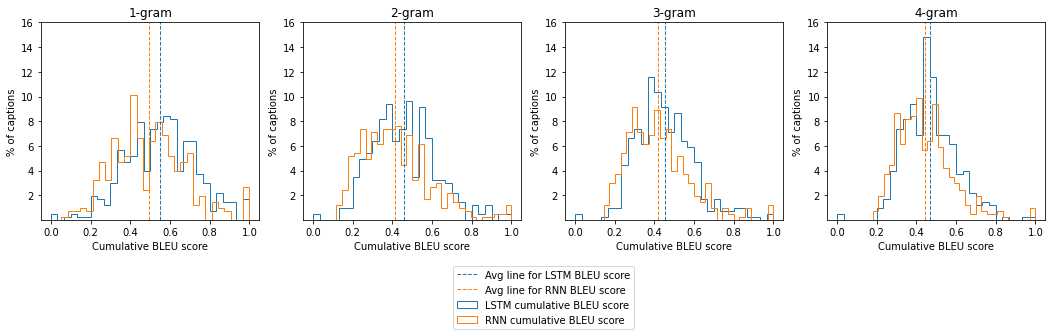

In [0]:
#@title

gap = 30
y = [40.5,81,121.5,162,202.5,243,283.5,324]
yfmt = [2,4,6,8,10,12,14,16]

plt.figure(figsize=(18,8))

plt.subplot(241)
plt.title('1-gram')
plt.hist(gram1_list,bins=gap,histtype='step',label='LSTM')
plt.axvline(garm1_avg, color='#1f77b4', lw=1, ls='--',label='Avg line for LSTM BLEU score')
plt.hist(gram1_list_rnn,bins=gap,histtype='step',label='RNN')
plt.axvline(garm1_avg_rnn, color='#ff7f0e', lw=1, ls='--',label='Avg line for RNN BLEU score')
plt.yticks(y,yfmt)
plt.ylabel('% of captions')
plt.xlabel('Cumulative BLEU score')

plt.subplot(242)
plt.title('2-gram')
plt.hist(gram2_list,bins=gap,histtype='step',label='LSTM')
plt.axvline(garm2_avg, color='#1f77b4', lw=1, ls='--',label='Avg line for LSTM BLEU score')
plt.hist(gram2_list_rnn,bins=gap,histtype='step',label='RNN')
plt.axvline(garm2_avg_rnn, color='#ff7f0e', lw=1, ls='--',label='Avg line for RNN BLEU score')
plt.yticks(y,yfmt)
plt.ylabel('% of captions')
plt.xlabel('Cumulative BLEU score')

plt.subplot(243)
plt.title('3-gram')
plt.hist(gram3_list,bins=gap,histtype='step',label='LSTM')
plt.axvline(garm3_avg, color='#1f77b4', lw=1, ls='--',label='Avg line for LSTM BLEU score')
plt.hist(gram3_list_rnn,bins=gap,histtype='step',label='RNN')
plt.axvline(garm3_avg_rnn, color='#ff7f0e', lw=1, ls='--',label='Avg line for RNN BLEU score')
plt.yticks(y,yfmt)
plt.ylabel('% of captions')
plt.xlabel('Cumulative BLEU score')

plt.subplot(244)
plt.title('4-gram')
plt.hist(gram4_list,bins=gap,histtype='step',label='LSTM cumulative BLEU score')
plt.axvline(garm4_avg, color='#1f77b4', lw=1, ls='--',label='Avg line for LSTM BLEU score')
plt.hist(gram4_list_rnn,bins=gap,histtype='step',label='RNN cumulative BLEU score')
plt.axvline(garm4_avg_rnn, color='#ff7f0e', lw=1, ls='--',label='Avg line for RNN BLEU score')
plt.yticks(y,yfmt)
plt.ylabel('% of captions')
plt.xlabel('Cumulative BLEU score')
plt.legend(bbox_to_anchor=(-1.3, -0.55), loc=8, borderaxespad=0)


plt.show()